# Índice:

* [1. Introdução](#intro)
* [2. Criando Baseline](#baseline)
* [2.1 Feature Engineering](#feature)
* [2.2 Modeling e Analysis](#ma)
* [2.2.1 Treino e teste](#tt)
* [2.2.2 Cross Validation](#cv)
* [3. Feature Importance](#importance)

## 1. Introdução <a id = "intro"></a>

Antes de entrar na criação do modelo, vamos entender alguns pontos que vão ajudar a compreender o que está acontecendo na análise das métricas utilizando a matriz de confusão.

A matriz de confusão nos permite analisar de forma detalhada o comportamento do nosso classificador, e para isso ela divide os resultados em quatro tipos:

* **True Positive(TP)**: Se refere aos casos que o modelo previu corretamente a classe positiva.

* **True Negative(TN)**: Se refere aos casos que o modelo previu corretamente a classe negativa.

* **False Positivo(FP)**: Se refere aos casos onde o modelo previu que era de uma classe positiva mas na verdade era da classe negativa.

* **False Negative(FN)**: Se refere aos casos onde o modelo previu que era de uma classe negativa mas na verdade era da classe positiva.

Para exemplificar uma matriz de confusão em um problema binário, segue abaixo um exemplo.

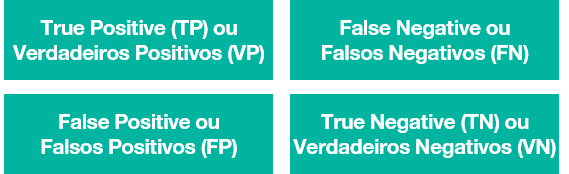

#### Métricas

Essas métricas são utilizadas para visualizar o comportamento do classificador e podemos responder algumas perguntas sobre o classificador.

* **Accuracy**: Qual a porcentagem de acertos do nosso classificador?
> $$ \frac{TP+FP}{TP+TN+FP+FN} $$

* **Precision**: Quando classifiquei como correto, quantos realmente estavam corretos?
> $$\frac{TP}{TP+FP}$$

* **Recall**: Com que frequência o classificador classifica os exemplos de uma classe? 
> $$\frac{TP}{TP+FN}$$

* **F1 Score**: É uma métrica que combina Recall e Precision, e indica a qualidade geral do modelo.
> $$\frac{2*Recall*Precision}{Recall + Precision}$$

## 2. Criando o baseline <a id = "baseline"></a>
Para a criação de um modelo inicial para nos basearmos, iremos seguir algumas etapas.

* Feature Engineering
* Modeling
* Performance Analysis


In [31]:
# importando bibliotecas
import pandas as pd #Manipulação do dataframe
from asd import dataset,metrics # Importando dataset e metricas
import numpy as np # Biblioteca de calculo cientifico
import matplotlib.pyplot as plt # Biblioteca de visualização
from sklearn import tree # Biblioteca do modelo de árvore de decisão
from sklearn.model_selection import train_test_split, cross_val_predict # Biblioteca de separação em treino e teste e validação cruzada
from sklearn.metrics import confusion_matrix # Biblioteca que gera matriz de confusão
from sklearn.utils.multiclass import unique_labels # Biblioteca geradora das labels

%matplotlib inline

In [32]:
# Criando dataframe
df = dataset.autism()
df.set_index('id',inplace = True)
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
id,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,0,1,1,0,1,0,0,...,m,Others,no,no,Jordan,no,5,4-11 years,Parent,NO
2,1,1,0,0,1,1,0,1,0,0,...,m,Middle Eastern,no,no,Jordan,no,5,4-11 years,Parent,NO
3,1,1,0,0,0,1,1,1,0,0,...,m,?,no,no,Jordan,yes,5,4-11 years,?,NO
4,0,1,0,0,1,1,0,0,0,1,...,f,?,yes,no,Jordan,no,4,4-11 years,?,NO
5,1,1,1,1,1,1,1,1,1,1,...,m,Others,yes,no,United States,no,10,4-11 years,Parent,YES


In [33]:
# Função de plotagem da matriz de confusão
def plot_confusion_matrix(y_test,result,cmap = plt.cm.Blues):
    # Confusion matrix
    cm = confusion_matrix(y_test,result)
    classe = unique_labels(y_test,result)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classe, yticklabels=classe,
           title= 'Matriz de confusão',
           ylabel='Rótulo real',
           xlabel='Rótulo previsto')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


### 2.1. Feature Engineering <a id = "feature"></a>

Nessa etapa será selecionado as features que vamos utilizar no modelo baseline.

In [34]:
# Selecionando colunas com os traços comportamentais.
columns = ['A{}_Score'.format(i) for i in range(1,11)]

# Separando em variáveis preditoras X e alvo da nossa predição Y
X = df[columns]
Y = df['Class/ASD']

# Para melhor entendimento do dataset, iremos renomear os valores de Y
Y = Y.replace({'NO':'Sem_Autismo','YES':'Autismo'})

### 2.2. Modeling e Analysis <a id = "ma"></a>

Nessa etapa aplicaremos o modelo que foi selecionado e com isso a contrução das predições do nosso modelo baseline.

* Modelo selecionado: Decision Tree
* Motivo: Fácil compreensão.

In [35]:
# Criação do modelo

baseline = tree.DecisionTreeClassifier()

Nessa parte testarei duas técnicas.

* Separando em treino e teste
* Validação cruzada

#### 2.2.1. Treino e Teste <a id = "tt"></a>

In [36]:
# Separando em treino e teste
x_train,x_test,y_train,y_test = train_test_split(X,Y,
                                                 test_size = 0.4,
                                                 random_state = 40)

# Treinando o modelo
test1 = baseline.fit(x_train,y_train)

results = test1.predict(x_test)


AttributeError: module 'asd.metrics' has no attribute 'confusion_performance'

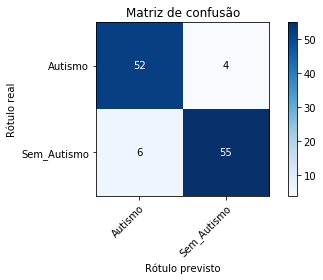

In [37]:
# Informações do modelo
plot_confusion_matrix(y_test,results)
metrics1 = metrics.confusion_performance(y_test,results)
plt.show()

In [ ]:
print("Métricas da matriz de confusão: \n")
print(metrics1)

#### 2.2.2. K-Fold Cross Validation <a id = "cv"></a>

A validação cruzada é uma técnica utilizada para evitar que o modelo se "acostume" com nossa base de dados e com isso não generalize novas informações.

**Funcionamento:**

Seu funcionamento se da em "dividir e testar", ou seja, os nossos dados são divididos em X partes, em cada uma dessas partes é novamente dividida em treino e teste e é testada então as partes e esse processo é repetido até que o modelo seja testado e treinado em todas essas partes e no final se calcula a métrica dos testes, dessa forma:

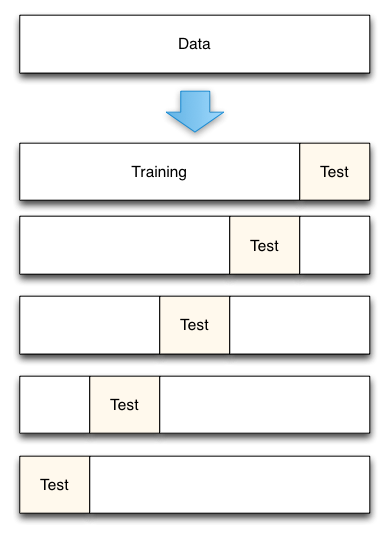

AttributeError: module 'asd.metrics' has no attribute 'confusion_performance'

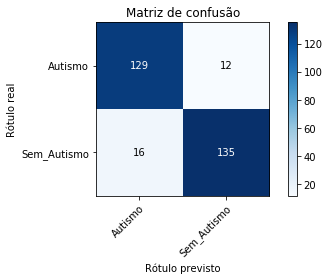

In [38]:
# Validação cruzada
results1 = cross_val_predict(baseline, X, Y,cv = 5)

# Informações do modelo
plot_confusion_matrix(Y,results1)
metrics2 = metrics.confusion_performance(Y,results1)
print("Métricas da matriz de confusão")
print(metrics2)
plt.show()
    

## 3. Feature Importance <a id ="importance"><a/>
    
Utilizar todos os atributos ao nosso alcance nem sempre é uma boa ideia, dependendo do problema isso não vai ficar legal. Então, para descobrir quais são as melhores features para criar o nosso modelo, é necessário aplicar algumas técnicas como: Qui², Importancia Gini ou Redução média da impureza, Importancia da permutação ou Redução média na precisão.

No nosso caso o modelo da biblioteca Sklearn, é baseado na Redução média da impureza.

In [56]:
dic = {i:baseline.feature_importances_[v] for v,i in enumerate(X.columns)}
dic

{'A1_Score': 0.06163901458019104,
 'A2_Score': 0.033350092173621594,
 'A3_Score': 0.07879244590230354,
 'A4_Score': 0.35454276873318719,
 'A5_Score': 0.06492374727668844,
 'A6_Score': 0.069061530336040122,
 'A7_Score': 0.048827262062556186,
 'A8_Score': 0.073527549671340509,
 'A9_Score': 0.06586943678446941,
 'A10_Score': 0.14946615247960193}